In [1]:
import logging
import os

import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

## Create Simulated Data ##

In [2]:
from replay_trajectory_classification.sorted_spikes_simulation import make_simulated_run_data

time, position, sampling_frequency, spikes, place_fields = make_simulated_run_data()

Plot the spikes and the position:

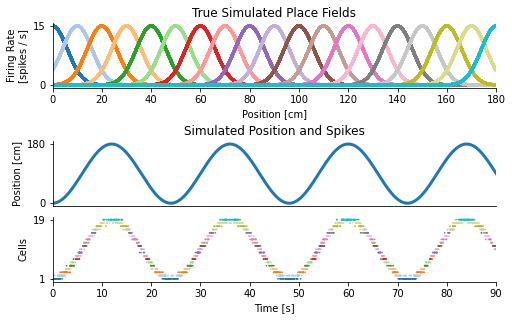

In [3]:
MM_TO_INCHES = 1.0 / 25.4
TWO_COLUMN = 178.0 * MM_TO_INCHES
GOLDEN_RATIO = (np.sqrt(5) - 1.0) / 2.0


spike_ind, neuron_ind = np.nonzero(spikes)
cmap = plt.get_cmap('tab20')

fig, axes = plt.subplots(3, 1, figsize=(TWO_COLUMN, TWO_COLUMN * GOLDEN_RATIO), constrained_layout=True)
for place_field, color in zip(place_fields.T, cmap.colors):
    axes[0].plot(position, place_field, linewidth=3, color=color)
axes[0].set_xlabel('Position [cm]')
axes[0].set_ylabel('Firing Rate\n[spikes / s]')
axes[0].set_title('True Simulated Place Fields')
axes[0].set_xlim((position.min(), position.max()))
axes[0].set_yticks([0, np.round(place_fields.max())])

axes[1].plot(time, position, linewidth=3)
axes[1].set_ylabel('Position [cm]')
axes[1].set_title('Simulated Position and Spikes')
axes[1].set_yticks([0, np.round(position.max())])
axes[1].set_xticks([])
axes[1].set_xlim((0.0, 90.0))

c = [cmap.colors[ind] for ind in neuron_ind]
axes[2].scatter(time[spike_ind], neuron_ind + 1, c=c, s=0.5)
axes[2].set_yticks((1, spikes.shape[1]))
axes[2].set_ylabel('Cells')

axes[2].set_xlabel('Time [s]')
axes[2].set_xlim((0.0, 90.0))

sns.despine()

### Fitting the Model ###

We can fit an encoding model by relating the position to the spikes (aka finding the place fields for each cell). Suppose we wanted to fit the animal's position while it is running.

First we use dask for parallelizing the fit.

Then we can fit the model. Here we set the movement variance of the random walk (`movement_var`) to be the same as the animal's while running. `replay_speed` acts as a multiplier on the movement variance, so the ultimate variance of the Gaussian random walk is `movement_var` * `replay_speed`. We set the `place_bin_size`, which controls the discretization of position, to be the standard deviation of the movement variance. Finally we set `knot_spacing` to 10 cm. This controls the smoothness of the place field and corresponds to how fast you expect the firing rate to change over position.

In [4]:
from replay_trajectory_classification import SortedSpikesDecoder
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, estimate_movement_var

movement_var = estimate_movement_var(position, sampling_frequency)

environment = Environment(place_bin_size=np.sqrt(movement_var))
transition_type = RandomWalk(movement_var=movement_var)

decoder = SortedSpikesDecoder(
    environment=environment,
    transition_type=transition_type,
    sorted_spikes_algorithm='spiking_likelihood_kde',
    sorted_spikes_algorithm_params={'block_size': None,
                                    'position_std': 3.0,
                                    'use_diffusion_distance': False},
)
decoder.fit(position, spikes)

INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting place fields...


SortedSpikesDecoder(environment=Environment(environment_name='', place_bin_size=0.5268625668325884, track_graph=None, edge_order=None, edge_spacing=None, is_track_interior=None, position_range=None, infer_track_interior=True, fill_holes=False),
                    infer_track_interior=True,
                    initial_conditions_type=UniformInitialConditions(),
                    sorted_spikes_algorithm='spiking_likelihood_kde',
                    sorted_spikes_algorithm_params={'block_size': None,
                                                    'position_std': 3.0,
                                                    'use_diffusion_distance': False},
                    transition_type=RandomWalk(environment_name='', movement_var=0.2775841643294236, movement_mean=0.0, use_diffusion=False))

We can access the fitted place fields:

In [5]:
decoder.place_fields_

<xarray.DataArray (position: 342, neuron: 19)>
array([[0.0146893 , 0.00592344, 0.00021617, ..., 0.        , 0.        ,
        0.        ],
       [0.0144644 , 0.00613825, 0.00024234, ..., 0.        , 0.        ,
        0.        ],
       [0.01420782, 0.00639076, 0.00027595, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00019678, 0.00588007,
        0.01433882],
       [0.        , 0.        , 0.        , ..., 0.00016516, 0.00562208,
        0.01445369],
       [0.        , 0.        , 0.        , ..., 0.00014009, 0.00540576,
        0.01454125]], dtype=float32)
Coordinates:
  * position  (position) float32 0.2632 0.7895 1.316 1.842 ... 178.7 179.2 179.7
Dimensions without coordinates: neuron

And plot them versus the true place fields:

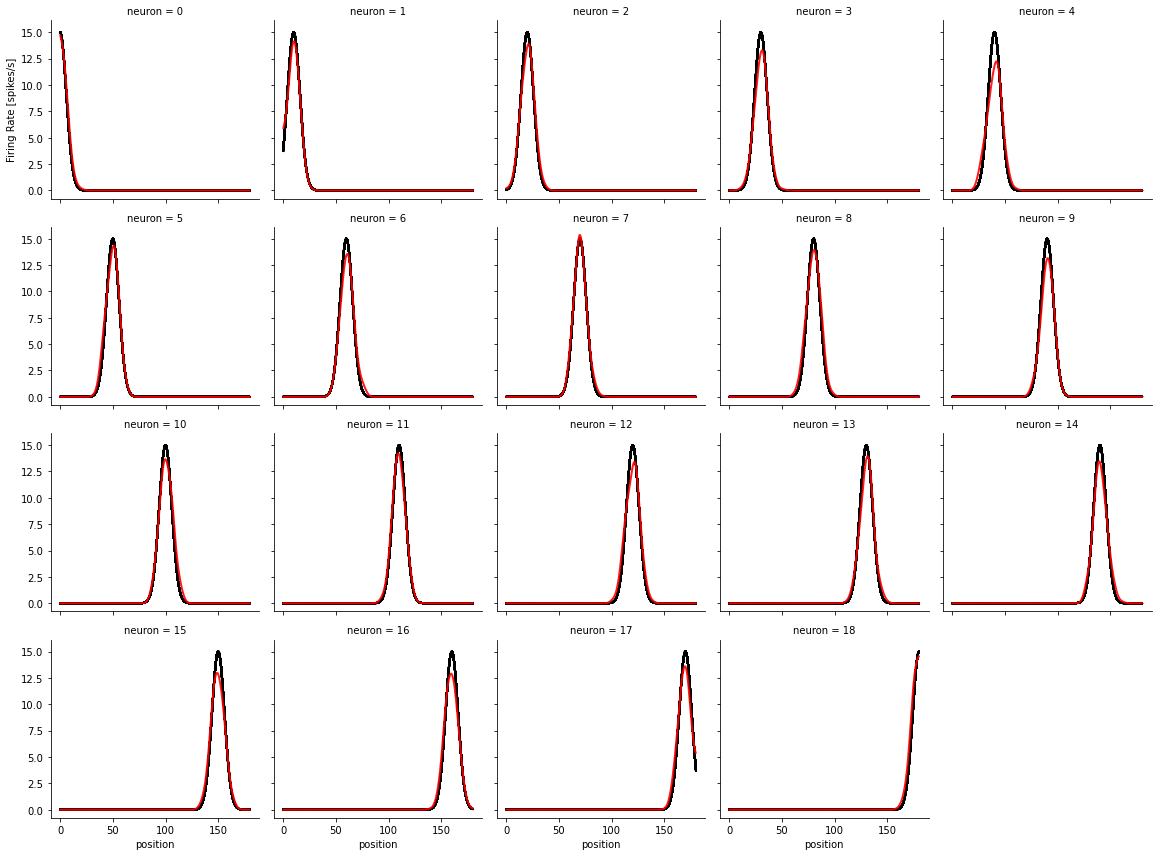

In [6]:
g = (decoder.place_fields_ * sampling_frequency).plot(
        x="position", col="neuron", col_wrap=5, color="red", linewidth=2, alpha=0.9, zorder=1, label="Predicted")
g.axes[0, 0].set_ylabel("Firing Rate [spikes/s]")
for ax, place_field in zip(g.axes.flat, place_fields.T):
    ax.plot(position, place_field, linewidth=2, color="black", zorder=-1, label="True")
sns.despine()

We can also plot the state transition model:

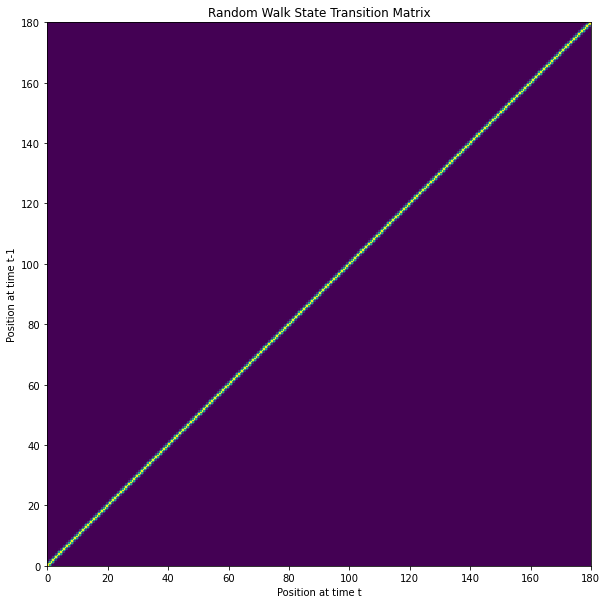

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

edge1, edge2 = np.meshgrid(decoder.environment.place_bin_edges_, decoder.environment.place_bin_edges_)
ax.pcolormesh(edge1, edge2, decoder.state_transition_.T, vmin=0.0, vmax=np.percentile(decoder.state_transition_, 99.9))
ax.set_title("Random Walk State Transition Matrix")
ax.set_ylabel("Position at time t-1")
ax.set_xlabel("Position at time t")
ax.axis("square");

## Predicting Position ##

We can predict the first 50,000 time bins, which produces an labeled array called `results`:

In [8]:
time_ind = slice(0, 50000)

results = decoder.predict(spikes[time_ind], time=time[time_ind], use_gpu=False)
results

INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...


<xarray.Dataset>
Dimensions:            (time: 50000, position: 342)
Coordinates:
  * time               (time) float64 0.0 0.001 0.002 0.003 ... 50.0 50.0 50.0
  * position           (position) float64 0.2632 0.7895 1.316 ... 179.2 179.7
Data variables:
    likelihood         (time, position) float64 0.9993 0.9992 ... 0.9998 1.0
    causal_posterior   (time, position) float32 0.002929 0.002929 ... 0.0 0.0
    acausal_posterior  (time, position) float32 0.046 0.06159 ... 0.0 0.0
Attributes:
    data_log_likelihood:  -726.859867658381

`results` has three main variables:
+ **likelihood** -- the probablility of spikes given position
+ **causal_posterior**: the probability of position given only past spikes
+ **acausal_posterior**: the probability of position given all past and future spikes

You'll probably want to use the **acausal_posterior**, but we can visualize both the acausal and causal and overlay the true position (magenta dashed line):

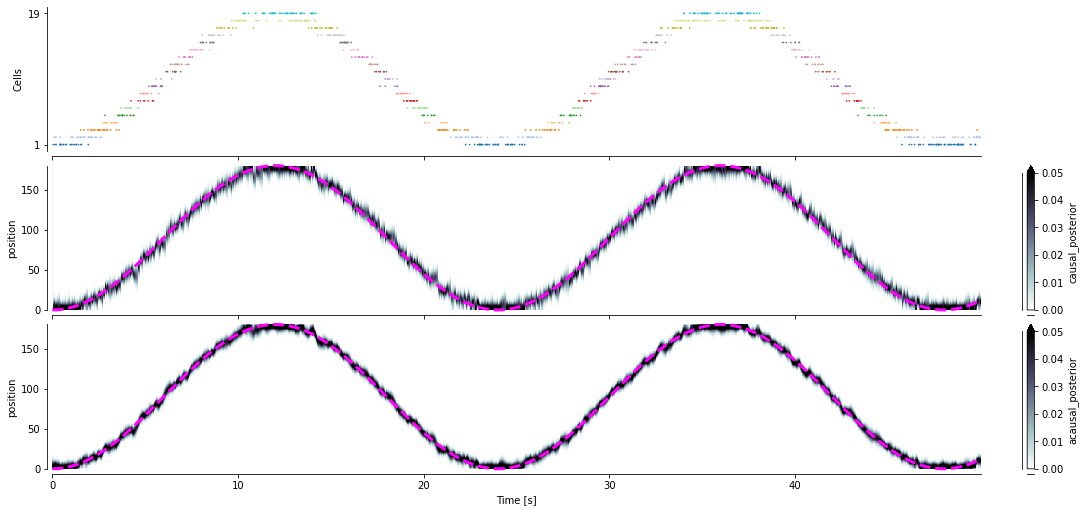

In [9]:
fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15, 7))

spike_ind, neuron_ind = np.nonzero(spikes[time_ind])
c = [cmap.colors[ind] for ind in neuron_ind]
axes[0].scatter(time[spike_ind], neuron_ind + 1, c=c, s=0.5, clip_on=False)
axes[0].set_yticks((1, spikes.shape[1]))
axes[0].set_ylabel('Cells')

results.causal_posterior.plot(x="time", y="position", ax=axes[1], cmap="bone_r", vmin=0.0, vmax=0.05, clip_on=False)
axes[1].plot(time[time_ind], position[time_ind], color="magenta", linestyle="--", linewidth=3, clip_on=False)
axes[1].set_xlabel("")
results.acausal_posterior.plot(x="time", y="position", ax=axes[2], cmap="bone_r", vmin=0.0, vmax=0.05, clip_on=False)
axes[2].plot(time[time_ind], position[time_ind], color="magenta", linestyle="--", linewidth=3, clip_on=False)
axes[2].set_xlabel('Time [s]')
sns.despine(offset=5)

From this, we can see, as expected, that the decoded position (given as a probability of position over time) matches the true position well.

## Example using Track Graph

For anything more complicated than a linear track, you will want to use the track graph to specify the correspondence of 1D and 2D position. Here is an example using a circular track.

### Simulated Data Setup
First we generate some data for a circular track. We also make a track graph (See `notebooks/tutorial/01-Introduction_and_Data_Format.ipynb` for more information on track graph creation)

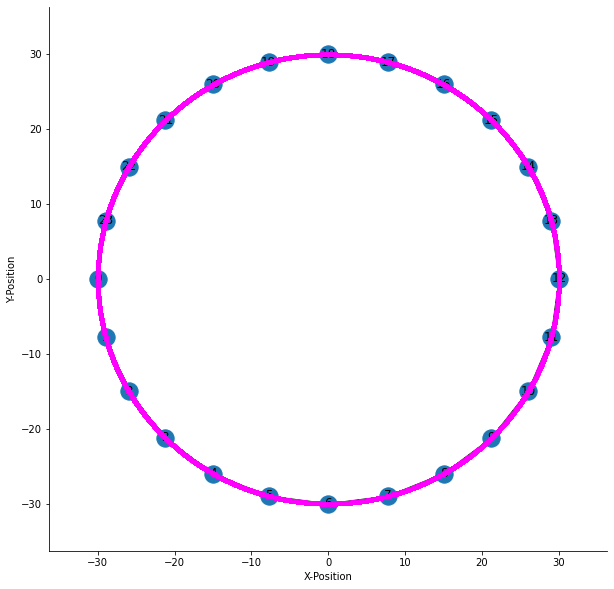

In [10]:
from replay_trajectory_classification import make_track_graph, plot_track_graph
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

angle = np.linspace(-np.pi, np.pi, num=24, endpoint=False)
radius = 30

node_positions = np.stack((radius * np.cos(angle), radius * np.sin(angle)), axis=1)

node_ids = np.arange(node_positions.shape[0])
edges = np.stack((node_ids, np.roll(node_ids, shift=1)), axis=1)

track_graph = make_track_graph(node_positions, edges)

position_angles = np.linspace(-np.pi, 31 * np.pi, num=360_000, endpoint=False)
position = np.stack((radius * np.cos(position_angles), radius * np.sin(position_angles)), axis=1)

fig, ax = plt.subplots(figsize=(10, 10))
plot_track_graph(track_graph, ax=ax)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("X-Position")
ax.set_ylabel("Y-Position")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.scatter(position[:, 0], position[:, 1], alpha=0.25, s=10, zorder=11, color="magenta")

If we want to linearize the track, we need to map the 2D position to 1D position. We do this by sepcifying the `edge_order` and `edge_spacing`:

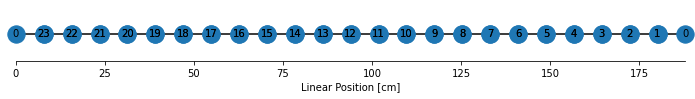

In [11]:
from replay_trajectory_classification import plot_graph_as_1D

edge_spacing = 0
n_nodes = len(track_graph.nodes)
edge_order = np.stack((np.roll(np.arange(n_nodes-1, -1, -1), 1),
                       np.arange(n_nodes-1, -1, -1)), axis=1)

fig, ax = plt.subplots(figsize=(n_nodes // 2, 1))
plot_graph_as_1D(track_graph,
                 edge_spacing=edge_spacing,
                 edge_order=edge_order,
                 ax=ax)

We can use the `track_linearization` package to linearize the track from 1D to 2D

In [12]:
from track_linearization import get_linearized_position

position_df = get_linearized_position(position, track_graph, edge_order=edge_order, edge_spacing=edge_spacing, use_HMM=False)
position_df

,linear_position,track_segment_id,projected_x_position,projected_y_position
0,0.000000,0,-30.000000,-3.673940e-15
1,187.949411,1,-29.998916,-8.235002e-03
2,187.941104,1,-29.997832,-1.647031e-02
3,187.932798,1,-29.996747,-2.470591e-02
4,187.924491,1,-29.995663,-3.294182e-02
...,...,...,...,...
359995,0.041533,0,-29.994579,4.117803e-02
359996,0.033226,0,-29.995663,3.294182e-02
359997,0.024919,0,-29.996747,2.470591e-02
359998,0.016612,0,-29.997832,1.647031e-02


Now let's check to see if the linearization looks correct.

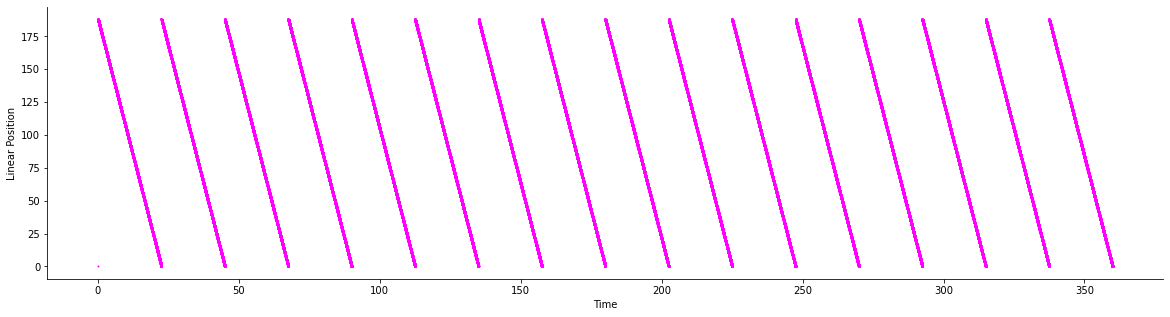

In [13]:
plt.figure(figsize=(20, 5))

sampling_frequency = 1000
time = np.arange(position_df.linear_position.size) / sampling_frequency
plt.scatter(time, position_df.linear_position, clip_on=False, s=1, color='magenta')
plt.xlabel('Time')
plt.ylabel('Linear Position')
sns.despine()

Now let's simulate neurons with 2D place fields. Here simulate 20 cells with place fields spaced equally around the track.

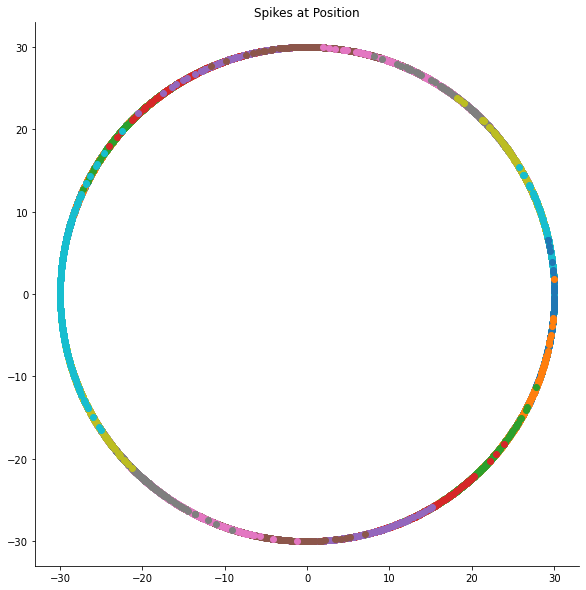

In [14]:
from replay_trajectory_classification.simulate import simulate_neuron_with_place_field

angle = np.linspace(-np.pi, np.pi, num=20, endpoint=False)

place_field_centers = np.stack((radius * np.cos(angle), radius * np.sin(angle)), axis=1)

spikes = np.stack([simulate_neuron_with_place_field(center, position, sampling_frequency=sampling_frequency, variance=6.0**2)
                   for center in place_field_centers[::-1]], axis=1)

fig, ax = plt.subplots(figsize=(10, 10))
for spike in spikes.T:
    spike_ind = np.nonzero(spike)[0]
    ax.scatter(position[spike_ind, 0], position[spike_ind, 1])
    
ax.axis("square")
ax.set_title('Spikes at Position')
sns.despine()

### Using the track graph with the decoder
**IMPORTANT!!!**

In order to get the proper transition matrix and binning of linear position, we need to specify:
+ `track_graph`
+ `edge_order`
+ `edge_spacing` 

in the environment.

This is the same as the linearization.

In [15]:
from replay_trajectory_classification import SortedSpikesDecoder

environment = Environment(place_bin_size=0.5,
                         track_graph=track_graph,
            edge_order=edge_order,
            edge_spacing=edge_spacing)
transition_type = RandomWalk(movement_var=0.25)

decoder = SortedSpikesDecoder(
    environment=environment,
    transition_type=transition_type,
)

decoder

SortedSpikesDecoder(environment=Environment(environment_name='', place_bin_size=0.5, track_graph=<networkx.classes.graph.Graph object at 0x7f41f2f3e910>, edge_order=array([[ 0, 23],
       [23, 22],
       [22, 21],
       [21, 20],
       [20, 19],
       [19, 18],
       [18, 17],
       [17, 16],
       [16, 15],
       [15, 14],
       [14, 13],
       [13, 12],
       [12, 11],
       [11, 10],
       [10,  9],
       [ 9,  8],
       [ 8,  7],
       [ 7,  6],
       [ 6,  5],
       [ 5,  4],
       [ 4,  3],
       [ 3,  2],
       [ 2,  1],
       [ 1,  0]]), edge_spaci..., fill_holes=False),
                    infer_track_interior=True,
                    initial_conditions_type=UniformInitialConditions(),
                    sorted_spikes_algorithm='spiking_likelihood_kde',
                    sorted_spikes_algorithm_params={'block_size': None,
                                                    'position_std': 6.0,
                                                    'use_

In [16]:
decoder.fit(position_df.linear_position,
            spikes)

INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting place fields...


SortedSpikesDecoder(environment=Environment(environment_name='', place_bin_size=0.5, track_graph=<networkx.classes.graph.Graph object at 0x7f41f2f3e910>, edge_order=array([[ 0, 23],
       [23, 22],
       [22, 21],
       [21, 20],
       [20, 19],
       [19, 18],
       [18, 17],
       [17, 16],
       [16, 15],
       [15, 14],
       [14, 13],
       [13, 12],
       [12, 11],
       [11, 10],
       [10,  9],
       [ 9,  8],
       [ 8,  7],
       [ 7,  6],
       [ 6,  5],
       [ 5,  4],
       [ 4,  3],
       [ 3,  2],
       [ 2,  1],
       [ 1,  0]]), edge_spaci..., fill_holes=False),
                    infer_track_interior=True,
                    initial_conditions_type=UniformInitialConditions(),
                    sorted_spikes_algorithm='spiking_likelihood_kde',
                    sorted_spikes_algorithm_params={'block_size': None,
                                                    'position_std': 6.0,
                                                    'use_

Again we can plot the place fields

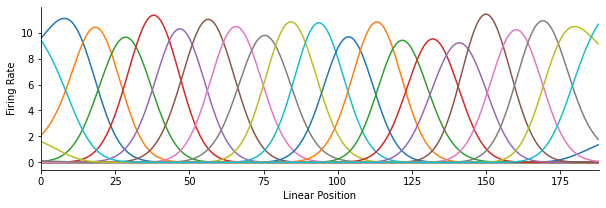

In [17]:
fig, ax = plt.subplots(figsize=(10, 3))
(decoder.place_fields_ * sampling_frequency).plot(x="position", hue="neuron", add_legend=False, ax=ax)
ax.set_xlabel('Linear Position')
ax.set_ylabel('Firing Rate')
ax.set_xlim((0, position_df.linear_position.max()))
sns.despine()

Here is the random walk transition matrix.

**Notice** that there is now a spot of color at the upper left and bottom right corner of the transition matrix that indicates the position can move between the first and last linear position (which makes sense because this is a circle).

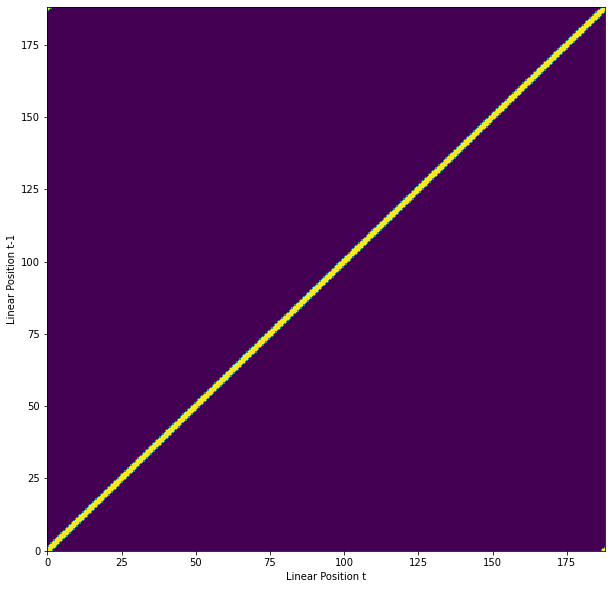

In [18]:
plt.figure(figsize=(10, 10))
bin1, bin2 = np.meshgrid(decoder.environment.place_bin_edges_, decoder.environment.place_bin_edges_)
plt.pcolormesh(bin1, bin2, decoder.state_transition_.T, vmin=0.0, vmax=0.01)
plt.xlabel('Linear Position t')
plt.ylabel('Linear Position t-1');

We can predict the data from the first 50,000 time points as before:

In [19]:
time_ind = slice(0, 50_000)
results = decoder.predict(spikes[time_ind], time=time[time_ind])

results

INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...


<xarray.Dataset>
Dimensions:            (time: 50000, position: 384)
Coordinates:
  * time               (time) float64 0.0 0.001 0.002 0.003 ... 50.0 50.0 50.0
  * position           (position) float64 0.2447 0.7342 1.224 ... 187.2 187.7
Data variables:
    likelihood         (time, position) float64 0.9989 0.9988 ... 0.9987 0.9987
    causal_posterior   (time, position) float32 0.002606 0.002606 ... 4.562e-13
    acausal_posterior  (time, position) float32 0.04053 0.03893 ... 4.562e-13
Attributes:
    data_log_likelihood:  -561.173403057641

And we can see that the linear position and decode match

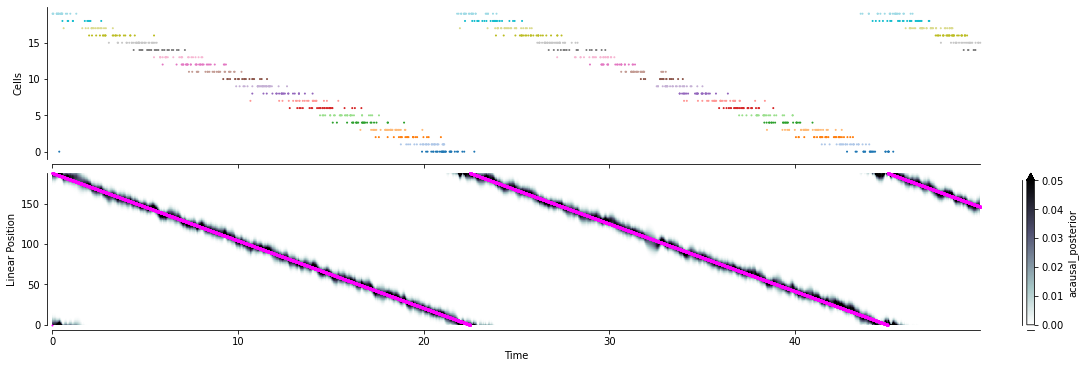

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(15, 5), sharex=True, constrained_layout=True)

spike_time_ind, neuron_ind = np.nonzero(spikes[time_ind])
cmap = plt.get_cmap('tab20')
c = [cmap.colors[ind] for ind in neuron_ind]
axes[0].scatter(time[time_ind][spike_time_ind], neuron_ind, clip_on=False, s=1, c=c)
axes[0].set_ylabel('Cells')

results.acausal_posterior.plot(x="time", y="position", ax=axes[1],
                               robust=True, cmap="bone_r", vmin=0.0, vmax=0.05,
                               clip_on=False)
axes[1].scatter(time[time_ind], position_df.iloc[time_ind].linear_position, color="magenta", s=1, clip_on=False)
axes[1].set_ylabel('Linear Position')
axes[1].set_xlabel('Time')
sns.despine(offset=5)

## Decoding in 2D

In [21]:
environment = Environment(place_bin_size=2.0)
transition_type = RandomWalk(movement_var=0.25, use_diffusion=False)

decoder = SortedSpikesDecoder(
    environment=environment,
    transition_type=transition_type,
    sorted_spikes_algorithm_params={'block_size': None,
                                    'position_std': 3.0,
                                    'use_diffusion_distance': False},
)

decoder.fit(position, spikes)

INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting place fields...


SortedSpikesDecoder(environment=Environment(environment_name='', place_bin_size=2.0, track_graph=None, edge_order=None, edge_spacing=None, is_track_interior=None, position_range=None, infer_track_interior=True, fill_holes=False),
                    infer_track_interior=True,
                    initial_conditions_type=UniformInitialConditions(),
                    sorted_spikes_algorithm='spiking_likelihood_kde',
                    sorted_spikes_algorithm_params={'block_size': None,
                                                    'position_std': 3.0,
                                                    'use_diffusion_distance': False},
                    transition_type=RandomWalk(environment_name='', movement_var=0.25, movement_mean=0.0, use_diffusion=False))

In [22]:
time_ind = slice(0, 50_000)
results = decoder.predict(spikes[time_ind], time=time[time_ind])

results

INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...


<xarray.Dataset>
Dimensions:            (time: 50000, x_position: 32, y_position: 32)
Coordinates:
  * time               (time) float64 0.0 0.001 0.002 0.003 ... 50.0 50.0 50.0
  * x_position         (x_position) float64 -31.0 -29.0 -27.0 ... 27.0 29.0 31.0
  * y_position         (y_position) float64 -31.0 -29.0 -27.0 ... 27.0 29.0 31.0
Data variables:
    likelihood         (time, x_position, y_position) float64 nan nan ... nan
    causal_posterior   (time, x_position, y_position) float32 nan nan ... nan
    acausal_posterior  (time, x_position, y_position) float32 nan nan ... nan
Attributes:
    data_log_likelihood:  -1184.294175540049

Here is the sum of the probability of 2D decoded positions overlayed with the true position

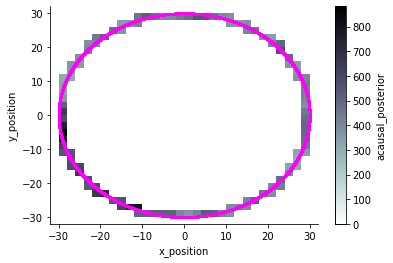

In [23]:
results.acausal_posterior.sum('time').plot(x='x_position', y='y_position', cmap='bone_r')
plt.scatter(position[time_ind, 0], position[time_ind, 1], color='magenta', s=1, clip_on=False, label='True Position')
sns.despine()

Here is the most likely position over time compared with the true position

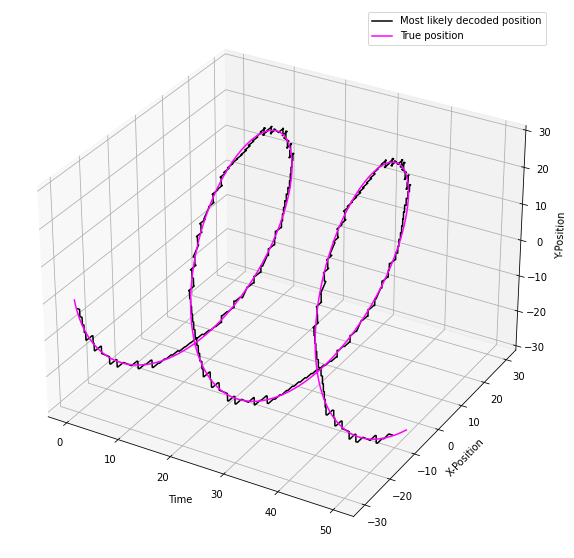

In [24]:
map_estimate = results.acausal_posterior.stack(position=['x_position', 'y_position'])
map_estimate = map_estimate.position[map_estimate.argmax('position')]
map_estimate = np.asarray(map_estimate.values.tolist())

plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot3D(results.time, map_estimate[:, 0], map_estimate[:, 1], 'black', label='Most likely decoded position')
ax.set_xlabel('Time')
ax.set_ylabel('X-Position')
ax.set_zlabel('Y-Position')

ax.plot3D(results.time, position[time_ind, 0], position[time_ind, 1], 'magenta', label='True position')
ax.set_xlabel('Time')
ax.set_ylabel('X-Position')
ax.set_zlabel('Y-Position')
plt.legend()

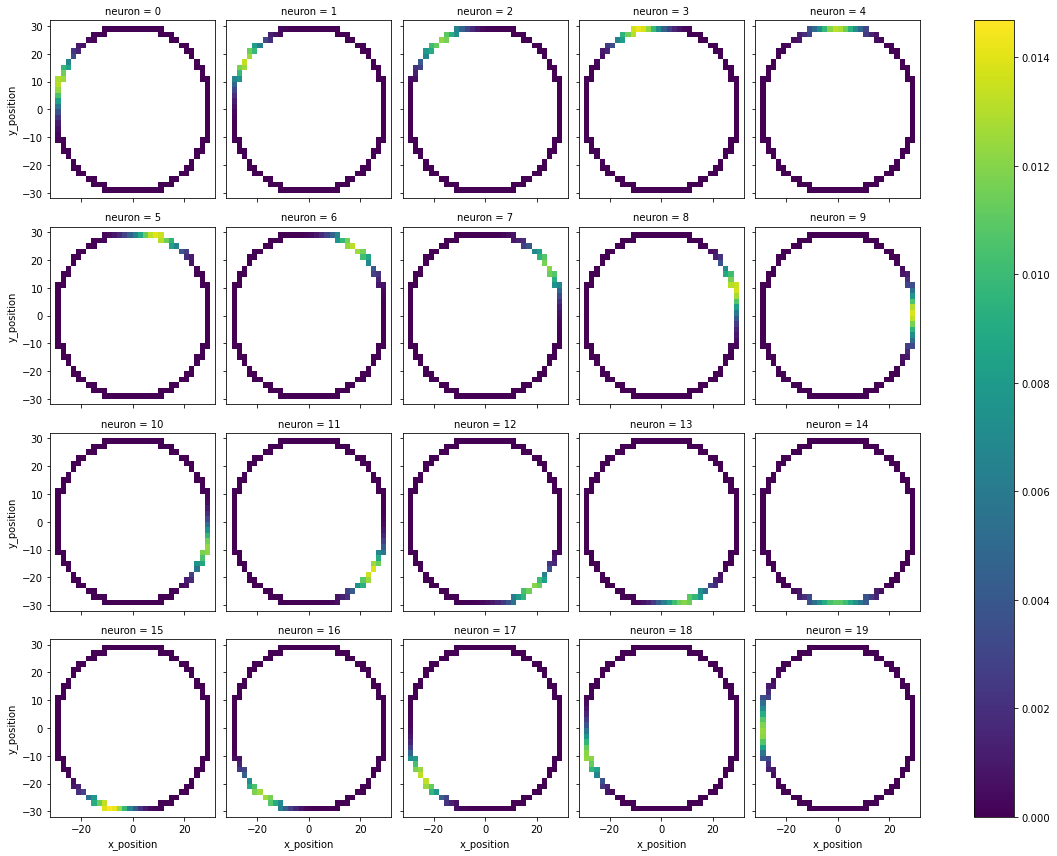

In [25]:
decoder.plot_place_fields()

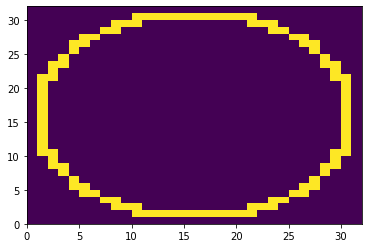

In [26]:
plt.pcolormesh(decoder.environment.is_track_interior_.T)